# makemore_WaveNet

----
* Inspired by Andrej Karpathy's ["Building makemore Part 5: Building a WaveNet"](https://www.youtube.com/watch?v=t3YJ5hKiMQ0)
* Supplementary links 
    - ["WaveNet" 2016 paper](https://arxiv.org/abs/1609.03499) from DeepMind
    - Bengio et al. 2003 MLP language model paper [(pdf)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
    - [Makemore Part 5 - Building a WaveNet](https://ansonchu.com/zero-to-hero/makemore-part-5-building-a-wavenet) - Anson Chu
        - excellent explanation for the premise behind `FlattenConsecutive`
    - s/o. Elena Voita's [blog](https://lena-voita.github.io/nlp_course/models/convolutional.html) on convolutional neural networks for text.

# Table of Contents
------------------
- [0. Makemore: Introduction](#0)
- [1. Multilayer Perceptron (MLP) Internals](#1)
    - [1.1. Starter Code](#101)
    - [1.2. Fixing Learning Rate Plot](#102)
    - [1.3. `PyTorch`-ifying our Code](#103)
- [2. WaveNet](#2)
    - [2.1. Overview](#201)
    - [2.2. Case 1: Set Context Size to 8](#202)
    - [2.3. WaveNet Implementation: Hierarchical Tree](#203)
    - [2.4. WaveNet: Training --> 1st Pass](#204)
    - [2.5. Fixing `BatchNorm1d` Bug](#205)
    - [2.6. WaveNet: Training --> 2nd Pass](#206)
    - [2.7. WaveNet: Scaling Up](#207)
- [3. Summary](#3)
    - [3.1. Experimental Harness](#301)
    - [3.2. WaveNet but with **"Dilated Causal Convolutions"**](#302)
    - [3.3. `torch.nn`](#303)
    - [3.4. Development Process of Building Deep Neural Nets (DNNs)](#304)
    - [3.5. Going Forward: Improvements !!!](#305)
- [4. Conclusion](#4)
------



# Appendix
---------------
## Figures
- [A1. WaveNet Architecture: Visualization of a Stack of Dilated Causal Convolutional Layers.](#a1)

## Tables
- [B1. Model Performance Log for Different Scenarios.](#b1)

## Definitions/Explanations
- [C1. `PyTorch` Containers](#c1)
- [C2. Dilated Convolutions](#c2)
- [C3. Convolutions: Kernel, Stride, Padding, Bias](#c3)


## [Exercises](#e1)

## [References](#r1)

-----------
<br><br>
# 0. Makemore: Introduction<a id="0"></a>
---------------------------------
<u>**Makemore**</u> takes one text file as input, where each line is assumed to be one training thing, and generates more things like it. Under the hood, it is an **autoregressive character-level language model**, with a <u>wide choice of models from bigrams all the way to a Transformer (exactly as seen in GPT)</u>. An [autoregressive model](https://en.wikipedia.org/wiki/Autoregressive_model) specifies that the output variable depends linearly on its own previous values and on a stochastic term (an imperfectly predictable term). For example, we can feed it a database of names, and makemore will generate cool baby name ideas that all sound name-like, but are not already existing names. Or if we feed it a database of company names then we can generate new ideas for a name of a company. Or we can just feed it valid scrabble words and generate english-like babble. 
```
"As the name suggests, makemore makes more."
```
This is not meant to be too heavyweight of a library with a billion switches and knobs. It is one hackable file, and is mostly intended for educational purposes. [PyTorch](https://pytorch.org) is the only requirement.

Current implementation follows a few key papers:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)


In the 3rd makemore tutorial notebook, we covered key concepts for training neural networks, including forward pass activations, backward pass gradients, and batch normalization, with a focus on implementing and optimizing MLPs and ResNets in `PyTorch`. We also introduced diagnostic tools to monitor neural network health and highlights important considerations like proper weight initialization and learning rate selection.

In the 4th makemore notebook which was an aside/detour, we implemented backpropagation manually to calculate the gradients for all the parameters of a 2-layer MLP neural network. Essentially, we built the full backpropagation through the neural network by hand step-by-step $-$ from the cross entropy loss, 2nd Linear layer, tanh layer, batchnorm layer, 1st Linear layer, to the embedding table $-$ instead of calling Pytorch autograd's `loss.backward()` function. This exercise was to enhance the full understanding of the magic of `loss.backward()` and gain a deeper knowledge of backpropagation.

In this notebook, we will continue from where we left off in the 3rd notebook of the makemore series. We will take the 2-layer MLP from part 3 of this series and make it deeper with a tree-like structure, arriving at a convolutional neural network (CNN) architecture similar to the one employed in the **WaveNet paper (2016) from Google DeepMind.** In the WaveNet paper, the same hierarchical architecture is implemented more efficiently using ***causal dilated convolutions (not yet covered).*** Along the way, we get a better sense of `torch.nn` and what it is and how it works under the hood, and what a typical deep learning development process looks like (<u>a lot of reading of documentation, keeping track of multidimensional tensor shapes, moving between jupyter notebooks and repository code, ...</u>).

---------
<br><br><a id="1"></a>
# 1. Multilayer Perceptron (MLP) Internals
-------------------------------------------------------

## 1.1.  Starter Code<a id="101"></a>
-----
Let's recap the MLP model we implemented in **part 2 (MLP) of the makemore series**.

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('../data/names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [5]:
# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

... --> y
..y --> u
.yu --> h
yuh --> e
uhe --> n
hen --> g
eng --> .
... --> d
..d --> i
.di --> o
dio --> n
ion --> d
ond --> r
ndr --> e
dre --> .
... --> x
..x --> a
.xa --> v
xav --> i
avi --> e


In [7]:
# Near copy paste of the layers we have developed in Part 3

# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

------
With the above code, we can now build the actual network structure. We'll do so just like before, with

>* an embedding layer with of size `(27, 10)`,<br>
>* a hidden layer of size `(30, 200)`,<br>
>* a Batch Normalization layer across the hidden layer output's second dimension,<br>
>* a Tanh activation function,<br>
>* a linear layer of size `(200, 27)`<br>

In [8]:
torch.manual_seed(42); # seed rng for reproducibility

In [9]:
# MLP 
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

C  = torch.randn((vocab_size, n_embd))   
layers = [
  Linear(n_embd * block_size, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
]

# parameter init
with torch.no_grad():
    # last layer: make less confident
    layers[-1].weight *= 0.1

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12097


In [10]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     if i >= 1000:
#         break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


------
## 1.2.  Fixing Learning Rate Plot<a id="102"></a>
-----
We need to fix the learning rate loss vs. iterations plot since currently it's very **sensitive/noisy** (high variance) during a full cycle of iterations. This wide distribution band of loss values is due to the fact that we are not only training in batches but we are using a small batch size. We need to average up uniform subsections of the losses to get a better representation of the loss values.

`.view()` tensor operation allows us to divide the list of losses into smaller uniform subsections of consecutive elements. Then we can take the mean of each smaller row chunk, via `.mean(1)` of each subsection, to get one representative value for each row/subsection. This will create a more visually coherent and smoother plot. 

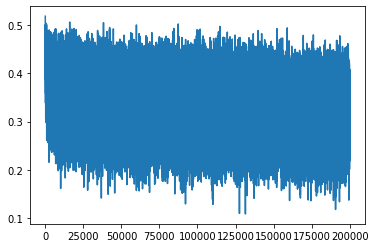

In [11]:
plt.plot(lossi);

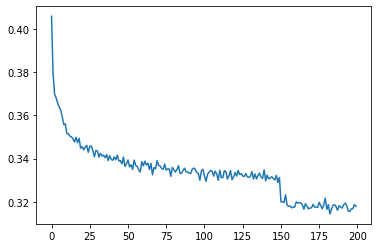

In [12]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

From the new smoother plot above, we observe an abrupt drop in learning rate at where the x-axis is ~$150$. This phenomenon is the ***learning rate decay.*** This new plot is more informative and even enables us to observe the learning rate decay effect which was completely hidden in the old noisy plot. In this case, we see that the learning rate decay subtracted a ton of energy out of the system and allowed us to settle into the local minimum in this optimization.

In [13]:
# put layers into eval mode (needed for batchnorm especially)
for layer in layers:
    layer.training = False

In [14]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    x = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


In [15]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        emb = C[torch.tensor([context])] # (1,block_size,n_embd)
        x = emb.view(emb.shape[0], -1) # concatenate the vectors
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


------
## 1.3.  `PyTorch`-ifying our Code<a id="103"></a>
-----
Next, we need to clean up our ***forward pass.*** Let's create class modules for `Embedding` and `Flatten`. Both classes perform the indexing operation in the forward pass and the flattening operation respectively. The names of these modules were inspired by `PyTorch`. Now we can re-initialize and optimize the neural network using these modules. We are treating the above modules as layers.


<a id="c1"></a>
Right now we are maintaining all our modules in a naked list of layers, however an additional way of `PyTorch`-ifying our code is to introduce the concept of `PyTorch` **containers**. In `torch.nn`, which we are basically rebuilding from scratch here, there's a concept of containers that are basically a way of organizing layers into lists or dictionaries. `torch.nn.Sequential()` is a module class in `PyTorch` that maintains a list of layers and passes a given input through all the layers sequentially as we're doing in out `layers` variable.

Let’s implement a `Sequential` class module, which contains a sequence of layers and passes the given input through each layer. Now instead of a raw standalone `layers` array, we now have a `model` object. Also, our forward pass simplifies to just:
```
# forward pass
logits = model(Xb)
loss = F.cross_entropy(logits, Yb) # loss function
```

In [16]:
# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
# -----------------------------------------------------------------------------------------------
class Flatten:
    def __call__(self,x):
        self.out = x.view(x.shape[0],-1)
        return self.out

    def parameters(self):
        return []
    
# -----------------------------------------------------------------------------------------------
class Sequential:

    def __init__(self,layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all the layers & stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]

In [17]:
torch.manual_seed(42); # seed rng for reproducibility

In [18]:
# MLP
n_embed = 10 # dimension of the character embedding
n_hidden = 200 # number of hidden neurons in a layer

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1 # last layer make less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

12097


In [19]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.2966
  10000/ 200000: 2.2322
  20000/ 200000: 2.4111
  30000/ 200000: 2.1004
  40000/ 200000: 2.3157
  50000/ 200000: 2.2104
  60000/ 200000: 1.9653
  70000/ 200000: 1.9767
  80000/ 200000: 2.6738
  90000/ 200000: 2.0837
 100000/ 200000: 2.2730
 110000/ 200000: 1.7491
 120000/ 200000: 2.2891
 130000/ 200000: 2.3443
 140000/ 200000: 2.1731
 150000/ 200000: 1.8246
 160000/ 200000: 1.7614
 170000/ 200000: 2.2419
 180000/ 200000: 2.0803
 190000/ 200000: 2.1326


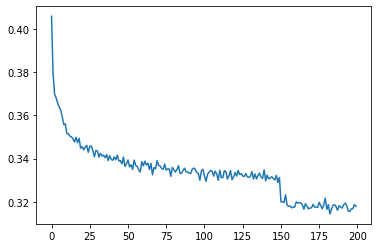

In [20]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [21]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [22]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0583250522613525
val 2.1065289974212646


-----
### Text Generation

The script below is implementing a simple version of a text generation model using `PyTorch`, specifically designed to generate sequences of characters to form names (based on dataset) based on a given initial context. Below are the steps explained:

>- ***Setting the Manual Seed:*** `torch.manual_seed(42)`<br>
This line sets the seed for `PyTorch` operations to ensure reproducibility. It means that every time you run this code, you'll get the same sequence of random numbers, making your results predictable.<br><br>
>- ***Looping Through Generations:*** `for _ in range(20)`<br>
The outer loop runs 20 times, indicating that the model will attempt to generate 20 different sequences of characters.<br><br>
>- ***Initialization of Context:*** `context = [0] * block_size` <br>
This initializes a list named `context` with `block_size` number of zeros. This list represents the starting point for generating a new sequence. The value `0` is likely a placeholder or a special token indicating the start of a sequence.<br><br>
>- ***Generating Sequences:*** `while True:`<br>
Inside the loop, there's a nested `while` loop that continues until a specific condition is met. This loop performs the actual generation of words.<br><br>
>- ***Forward Pass and Sampling:***<br>
>``` 
logits = model(torch.tensor([context]))
probs = F.softmax(logits, dim=1)
ix = torch.multinomial(probs, num_samples=1).item()
>```
>1. The model takes the current context as input and generates `logits` (raw scores before normalization).
>2. These logits are then passed through a softmax function to convert them into probabilities (`probs`), representing the likelihood of each possible next character.
>3. A character is sampled from these probabilities using `torch.multinomial`, which selects one index (`ix`) according to the probability distribution defined by `probs`.<br><br>  
>- ***Updating Context and Storing Samples:***<br>
>``` 
context = context[1:] + [ix]
out.append(ix)
>```
>1. The context is updated by removing the first element (the oldest character) and appending the newly sampled character (`ix`). This effectively shifts the context window one position to the right.
>2. The sampled index (`ix`) is also stored in the `out` list, which keeps track of the entire generated sequence.<br><br> 
>- ***Breaking Condition:***<br>
>``` 
if ix == 0:
    break
>```
>1. The loop breaks if the sampled character is `0`. This could be a special token used to indicate the end of a sentence or sequence.<br><br>  
>- ***Printing Generated Sequence:***  `print(''.join(itos[i] for i in out))`<br>
After the generation process is complete for a single sequence, the script prints the generated sequence by mapping indices back to characters (`itos` is a list of characters corresponding to their indices).<br><br>

In summary, this script uses a pre-trained language model to generate names as sequences of characters, starting from a given context and ending when a special token is generated. Each generation attempt is independent, and the process is repeated 20 times. The better our model, the more likely the generated names sound like actually names.


---

In [23]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

ivon.
fanili.
thoommara.
kelo.
matyn.
leandr.
aleigh.
koldeniah.
prus.
carleen.
jah.
jorra.
alaya.
shonan.
vishylaharia.
juna.
vio.
orven.
mina.
laylee.


---
During the inference time, reset the batchnorm layer’s training mode to false. Otherwise, it will try to pass a single example through the network and cause bugs. The model will try to calculate the variance of a single example, which is nan (not a number).

Since our train and validation losses are very similar, we can predict that our model is not overfitting. Thus, there is room for further performance improvements such as scaling up the size of the neural network by making everything bigger and deeper. Currently in the first layer, we are squeezing our information so fast, which creates a bottleneck in the model. Thus, we need a slower way to squeeze our inputs.

Hence, we will be using the wavenet architecture.

---------
<br><br><a id="2"></a>
# 2. WaveNet
-------------------------------------------------------
Recall our 2-layer MLP architecture from the Bengio 2003 neural probabilistic LM paper. 
![bengio_2003_LM_architecture.png](https://images.spr.so/cdn-cgi/imagedelivery/j42No7y-dcokJuNgXeA0ig/13818c17-8299-4d82-bb0c-8fa2cc0d6fce/Untitled/w=3840,quality=100,fit=scale-down)<br><br>
Also recall how we tried to make the MLP deeper by stacking more hidden layers
![MLP_layers.png](https://images.spr.so/cdn-cgi/imagedelivery/j42No7y-dcokJuNgXeA0ig/6f7cc884-3493-4131-b26e-4ff57cafbdec/Untitled/w=828,quality=100,fit=scale-down)
[Source](https://ansonchu.com/zero-to-hero/makemore-part-5-building-a-wavenet)<br><br>

Despite adding more hidden layers, we are still "crushing" the context of the input layer **too soon** and this limits our ability to increase our context length. Essentially, we want to fuse the initial earlier layers together progressively, like in the WaveNet paper, to avoid this issue.<br><br>

------
## 2.1.  Overview<a id="201"></a>
-----
<u>***"WaveNet: A Generative Model for Raw Audio"***,</u> 12 Sep, 2016.<br>
<u>Abstract:</u><br>
This paper introduces WaveNet, a deep neural network for generating raw audio waveforms. The model is **fully probabilistic and autoregressive,** with the predictive distribution for each audio sample conditioned on all previous ones; nonetheless we show that it can be efficiently trained on data with tens of thousands of samples per second of audio. <u>When applied to text-to-speech, it yields state-of-the-art performance, with human listeners rating it as significantly more natural sounding than the best parametric and concatenative systems for both English and Mandarin.</u> A single WaveNet can capture the characteristics of many different speakers with equal fidelity, and can switch between them by conditioning on the speaker identity. When trained to model music, we find that it generates novel and often highly realistic musical fragments. We also show that it can be employed as a discriminative model, returning promising results for phoneme recognition.

**Keywords**: probabilistic autoregressive DNN, discriminative model, dilated causal convolutions

<br><br>
<img src="https://jeddy92.github.io/images/ts_conv/WaveNet_gif.gif" style="float: left; margin-right: 10px;" alt="WaveNet Gif">
<br><br><br><br><br><br><br><br><br><br><br><br><br><br><br><br>
[Source](https://jeddy92.github.io/ts_seq2seq_conv/)

<br><br>
The above animation shows how a WaveNet is structured. It is a fully convolutional neural network, where the convolutional layers have various dilation factors that allow its receptive field to grow exponentially with depth and cover thousands of timesteps. At the input layer, the **kernel size is $2$ and the stride is $2$.** (See [Convolution Section](#c3) in Appendix for more on kernels and strides).<br><br>
According to the Google Deepmind WaveNet [blog](https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/): *"At training time, the input sequences are real waveforms recorded from human speakers. After training, we can sample the network to generate synthetic utterances. At each step during sampling a value is drawn from the probability distribution computed by the network. This value is then fed back into the input and a new prediction for the next step is made. Building up samples one step at a time like this is computationally expensive, but we have found it essential for generating complex, realistic-sounding audio."*
<a id="c2"></a>


At the heart of WaveNet’s magic is the **dilated causal convolution layer**, which allows it to <u>properly treat temporal order and handle long-term dependencies without an explosion in model complexity.</u> Below is a nice visualization of its structure from the WaveNet paper.

<br><br><a id="a1"></a>
![wavenet architecture: dilated_causal_convolution](_imgs/dilated_causal_convolution.png)
**Figure 1: WaveNet Architecture: Visualization of a Stack of Dilated Causal Convolutional Layers.** ([Source](https://arxiv.org/pdf/1609.03499))<br><br>


The dilated causal convolution layer is the default building block. **Causal convolutions** provide the proper tool for handling temporal flow, but we need an additional modification to properly handle long-term dependencies. One of the problems of causal convolutions is that they require many layers, or large filters to increase the receptive field. With a time series that has a large number of steps, using simple causal convolutions to learn from the entire history would quickly make a model significantly more computationally and statistically complex. Instead of making that mistake, WaveNet uses **dilated convolutions**, which allow the <u>receptive field</u> to increase exponentially as a function of the convolution layer depth. In the "WaveNet" paper, dilated convolutions were used to increase the receptive field by orders of magnitude, without greatly increasing computational cost. A <u>dilated convolution</u> (also called "a trous", or convolution with holes) is a convolution where the filter is applied over an area larger than its length by skipping input values with a certain step. It is equivalent to a convolution with a larger filter derived from the original filter by dilating it with zeros, but is significantly more efficient.

------
## 2.2.  Case 1: Set Context Size to 8<a id="202"></a>
-----

First, let’s change the block size from $3$ to $8$.

In [24]:
# build the dataset
block_size = 8 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [25]:
for x,y in zip(Xtr[:20], Ytr[:20]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [26]:
torch.manual_seed(42); # seed rng for reproducibility

In [27]:
# MLP
n_embed = 10 # dimension of the character embedding
n_hidden = 200 # number of hidden neurons in a layer

model = Sequential([
    Embedding(vocab_size, n_embed),
    Flatten(),
    Linear(n_embed*block_size, n_hidden, bias = False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

22097


In [28]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.2847
  10000/ 200000: 2.0647
  20000/ 200000: 1.9722
  30000/ 200000: 2.0948
  40000/ 200000: 1.9738
  50000/ 200000: 2.1287
  60000/ 200000: 2.3574
  70000/ 200000: 1.9131
  80000/ 200000: 2.0735
  90000/ 200000: 2.0968
 100000/ 200000: 1.4963
 110000/ 200000: 2.1294
 120000/ 200000: 2.2324
 130000/ 200000: 2.2071
 140000/ 200000: 2.2326
 150000/ 200000: 1.8908
 160000/ 200000: 1.6867
 170000/ 200000: 2.0968
 180000/ 200000: 1.7824
 190000/ 200000: 1.9151


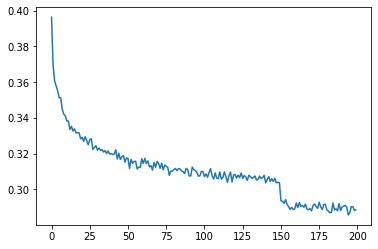

In [29]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [30]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [31]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9163435697555542
val 2.034247636795044


Increasing the context size only improves model performance from baseline case.

------
## 2.3. WaveNet Implementation: Hierarchical Tree<a id="203"></a>
-----
`PyTorch` matrix multiplication is powerful and can multiply matrices with multiple dimensions. Let’s run the following code.

```
(torch.randn((4,5,80))@ torch.randn((80,200))).shape
```

Matrix multiplication considers only the last dimension of the $\boldsymbol{1st}$ matrix. The remaining dimensions in the first matrix are treated as batch dimensions. This is convenient since we do not want to fully flatten the embedding vector. The consecutive elements should be grouped and processed in parallel. We must prevent the flatten layer from fully flattening.

Let's see how we can perform parallel processing of bigram groups (i.e. consecutive element groupings) in a batch-size dimension of an individual example and also over the actual batch-size dimension of the total examples in a batch-size.

In the WaveNet paper, the inputs are slowly crushed via the idea of ***Progressive Fusion.*** We want to make the network deeper and at each level, we want to fuse only 2 consecutive elements and create a new neuron in the next layer (`2 characters -> 2 bigrams -> 2 (4)-grams -> ...`). We implement this in a tree-like hierarchical manner.

Let’s say we have a hypothetical batch of 4 examples.
*   **Xb** is `4 examples x 8 characters`.
*   output of **embedding** is `4 examples x 8 characters x 10 embedding dimensions` where each character got transformed into a 10 dimension vector.
*   output of **flatten** is `4 examples x 80 character embeddings` where the embeddings of all 8 characters got flattened or concatenated into a single array.
*   output of **linear** layer is `4 examples x 200 neurons` otherwise known as 200 “channels.”


In [32]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix] 
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 16, 18,  9, 19,  9, 12],
        [ 0,  0,  0, 12,  5, 12,  1, 14],
        [ 0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0,  0,  0, 11,  1, 20,  9]])

In [33]:
model.layers[0].out.shape # output of Embedding layer (batch size, block size, embedding size)

torch.Size([4, 8, 10])

In [34]:
model.layers[1].out.shape # output of Flatten layer (batch size, input dimension=block size * embedding size)

torch.Size([4, 80])

In [35]:
model.layers[2].out.shape # output of 1st Linear layer (batch size, hidden layer neurons)

torch.Size([4, 200])

In [36]:
(torch.randn(4, 80) @ torch.randn(80, 200) + torch.randn(200)).shape

torch.Size([4, 200])

In [37]:
(torch.randn(4, 4, 20) @ torch.randn(20, 200) + torch.randn(200)).shape # linear layer for wavenet 3D

torch.Size([4, 4, 200])

In [38]:
list(range(10))[1::2]

[1, 3, 5, 7, 9]

In [39]:
list(range(10))[::2]

[0, 2, 4, 6, 8]

In [40]:
# mini-batch size of 4: want e to be (4, 4, 20) where consecutive 10-d vectors get concatenated
e = torch.randn(4, 8, 10)

#explicitly concatenate
method1 = torch.cat( [e[:,::2,:], e[:,1::2,:]], dim = 2)

# use .view operation
method2 = e.view(4, 4, 20)

#Check the similarity 
(method1 == method2).all()

tensor(True)

In [41]:
torch.cat([e[:,::2,:], e[:,1::2,:]], dim = 2).shape

torch.Size([4, 4, 20])

In [42]:
 e.view(4, 4, 20).shape, #e.view(4, -1).shape

(torch.Size([4, 4, 20]),)

----
We can update our `Flatten` module in the cells above to implement parallel processing and call it `FlattenConsecutive`. 

In [43]:
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self,n):
        self.n = n

    def __call__(self,x):
        B , T , C = x.shape
        x = x.view(B, T//self.n, C*self.n)

        # previous case, full flattening
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []

**Reducing `n_hidden`**

Before we move on, we will just reduce our `n_hidden` (or channel dimension) from $200$ to $68$ so that our total number of parameters stays approximately the same.

This will allow our performances to be more comparable, and allow us to isolate the impact of progressive fusing, and not conflating that with just increasing the number of parameters.

The performance ends up being about the same as before.

In [44]:
# original network
# n_embd = 10 # the dimensionality of the character embedding vectors
# n_hidden = 300 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(8), Linear(n_embd * 8, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

# hierarchical network
# n_embd = 24 # the dimensionality of the character embedding vectors
# n_hidden = 128 # the number of neurons in the hidden layer of the MLP
# model = Sequential([
#   Embedding(vocab_size, n_embd),
#   FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size),
# ])

In [45]:
torch.manual_seed(42); # seed rng for reproducibility

In [46]:
# MLP
n_embed = 10 # dimension of the character embedding
n_hidden = 68 # number of hidden neurons in a layer


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight *= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

22397


In [47]:
ix = torch.randint(0, Xtr.shape[0], (4,)) # let's look at a batch of just 4 examples
Xb, Yb = Xtr[ix], Ytr[ix] 
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0,  0, 13,  9, 12,  9,  1],
        [ 0,  0,  0,  1, 22,  1, 12, 25],
        [ 0,  0,  0,  0,  0,  0,  0, 10],
        [ 0,  0,  0,  0, 11,  8, 25, 14]])

-----
If we inspect the shapes of the output of each layer…

*   Embedding: `4x8x10` (batch of 4, 8 characters each, 10 embedding dimensions)
*   FlattenConsecutive: `4x4x20` (batch of 4, **4 groups**, 2x10=20 flattened embeddings dimensions)

    *   Linear: `4x4x68` (batch of 4, 4 groups, **68 channels**)
    *   BatchNorm1d: `4x4x68`
    *   Tanh: `4x4x68`

*   FlattenConsecutive: `4x2x136` (batch of 4, **2 groups**, 2x68=136 flattened channels)

    *   Linear: `4x2x68` (batch of 4, 2 groups, **68 channels**)
    *   BatchNorm1d: `4x2x68`
    *   Tanh: `4x2x68`

*   FlattenConsecutive: `4x136` (batch of 4, **1 group squeezed**, 2x68=136 flattened channels)

    *   Linear: `4x68` (batch of 4, **68 channels**)
    *   BatchNorm1d: `4x68`
    *   Tanh: `4x68`

*   Linear `4x27` (batch of 4, fan-out 27)

In [48]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (4, 8, 10)
FlattenConsecutive : (4, 4, 20)
Linear : (4, 4, 68)
BatchNorm1d : (4, 4, 68)
Tanh : (4, 4, 68)
FlattenConsecutive : (4, 2, 136)
Linear : (4, 2, 68)
BatchNorm1d : (4, 2, 68)
Tanh : (4, 2, 68)
FlattenConsecutive : (4, 136)
Linear : (4, 68)
BatchNorm1d : (4, 68)
Tanh : (4, 68)
Linear : (4, 27)


In [49]:
logits.shape

torch.Size([4, 27])

Basically, every time we go through a `FlattenConsecutive(2)`, we reduce the number of groups by 2. In the last `FlattenConsecutive`, since we end up with a single group, that dimension gets squeezed out. Implementing `FlattenConsecutive(2)` 3 times is equivalent (in terms of shape) to calling `FlattenConsecutive(8)` a single time.
![image](https://images.spr.so/cdn-cgi/imagedelivery/j42No7y-dcokJuNgXeA0ig/99d2b003-9579-4b10-be77-82c07a2b1d41/Untitled/w=1920,quality=80,fit=scale-down)
[Source](https://ansonchu.com/zero-to-hero/makemore-part-5-building-a-wavenet)<br><br>
Also note that every time we go through a `Linear` layer, we fan-out back to 68 channels. This does not change. It is only the group dimension that is being crushed at each `FlattenConsecutive` layer.

------
## 2.4.  WaveNet: Training --> 1st Pass<a id="204"></a>
-----

In [50]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.3068
  10000/ 200000: 2.2027
  20000/ 200000: 2.4151
  30000/ 200000: 2.1973
  40000/ 200000: 1.9878
  50000/ 200000: 2.0935
  60000/ 200000: 2.0564
  70000/ 200000: 1.8841
  80000/ 200000: 1.9829
  90000/ 200000: 1.9339
 100000/ 200000: 1.6718
 110000/ 200000: 2.4960
 120000/ 200000: 2.2628
 130000/ 200000: 2.0323
 140000/ 200000: 2.2900
 150000/ 200000: 1.8916
 160000/ 200000: 2.0737
 170000/ 200000: 2.0248
 180000/ 200000: 2.0343
 190000/ 200000: 1.9166


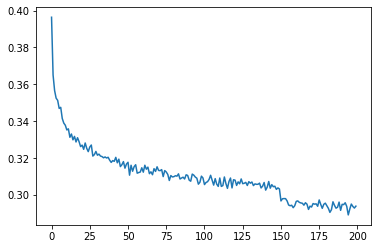

In [51]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [52]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [53]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9413423538208008
val 2.028500556945801


------
## 2.5.   Fixing `BatchNorm1d` Bug<a id="205"></a>
-----
We introduced a few bugs while improving the network with a hierarchical architecture which we need to fix.

Previously, in the batchnorm layer, we averaged across the columns. Our current `BatchNorm1d` only accounts for $2D$ inputs. However, this is not accurate for the WaveNet architecture because WaveNet has multidimensional ($3D$) inputs. This issue was not apparent due to tensor broadcasting property.

```
xmean = x.mean(0, keepdim = True)  # batch mean
xvar = x.var(0, keepdim = True, unbiased = True)  # batch variance
```

The previously used code will only take the mean and variance across the first (batch) dimension. The `dim` parameter of the `torch.mean()` function can be a tuple. Thus, we can use it to calculate the mean across multiple dimensions (batch & character). Now, we can use it to calculate the correct running parameters over the entire batch.

In [54]:
e = torch.randn(32, 4, 68)
emean = e.mean((0, 1), keepdim=True)  # 1, 4, 68
evar = e.var((0, 1), keepdim=True)  # 1, 4, 68
ehat = (e - emean) / torch.sqrt(evar + 1e-5) # 32, 4, 68
e.shape

torch.Size([32, 4, 68])

In [55]:
emean.shape

torch.Size([1, 1, 68])

In [56]:
model.layers[3].running_mean.shape # (1, 1, 68)

torch.Size([1, 4, 68])

------
## 2.6.   WaveNet: Training --> 2nd Pass<a id="206"></a>
-----
Let's update our `batchnorm1d` module and then we can train our network.

In [57]:
# -----------------------------------------------------------------------------------------------
class Linear:
  
    def __init__(self, fan_in, fan_out, init_type = "Kaiming", bias=True):
        if init_type == 'Kaiming':
            self.weight = torch.randn((fan_in, fan_out)) / fan_in**0.5 # note: kaiming init
        elif init_type == 'Xavier':
            self.weight = nn.init.xavier_uniform_(torch.randn((fan_in, fan_out)))  # Use Xavier initialization
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d: # (N, C), (N, L, C)

    def __init__(self, dim, eps=1e-8, momentum=0.1): # eps=1e-8, 1e-5
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True) # batch mean
            xvar = x.var(dim, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]

# -----------------------------------------------------------------------------------------------
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]
    
# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:

    def __init__(self,n):
        self.n = n

    def __call__(self,x):
#         print(f"Input shape before flattening: {x.shape}")
        B , T , C = x.shape
        x = x.view(B, T//self.n, C*self.n)    # Adjusted to correctly flatten the feature dimension
#         print(f"Shape after flattening: {x.shape}")

        # previous case, full flattening
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []
    
# -----------------------------------------------------------------------------------------------
class Sequential:

    def __init__(self,layers):
        self.layers = layers

    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        # get parameters of all the layers & stretch them out into one list
        return [p for layer in self.layers for p in layer.parameters()]
    
# --------------------------------------------------------------------------------------------------------
class Dropout:

    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, x):
        if self.train:
            mask = torch.bernoulli(torch.ones_like(x) * (1 - self.p))
            self.out = x * mask / (1 - self.p)
        return self.out

    def parameters(self):
        return []

    def train(self):
        self.training = True

#     def eval(self):
#         self.training = False

In [58]:
# MLP
torch.manual_seed(42) # seed rng for reproducibility
n_embed = 10 # dimension of the character embedding
n_hidden = 68 # number of hidden neurons in a layer

model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

22397


In [59]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.3142
  10000/ 200000: 2.2095
  20000/ 200000: 2.1495
  30000/ 200000: 2.1232
  40000/ 200000: 1.9628
  50000/ 200000: 2.4183
  60000/ 200000: 1.9633
  70000/ 200000: 1.8959
  80000/ 200000: 2.1884
  90000/ 200000: 1.8160
 100000/ 200000: 1.5932
 110000/ 200000: 2.3607
 120000/ 200000: 2.3665
 130000/ 200000: 1.9098
 140000/ 200000: 2.2288
 150000/ 200000: 1.7120
 160000/ 200000: 1.8514
 170000/ 200000: 1.9996
 180000/ 200000: 2.1041
 190000/ 200000: 1.6968


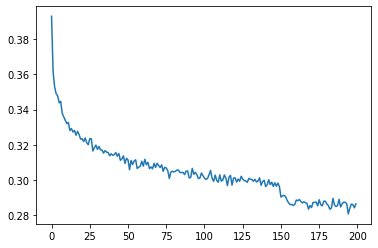

In [60]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [61]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [62]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.9110225439071655
val 2.0201878547668457


------
## 2.7.  WaveNet: Scaling Up<a id="207"></a>
-----
Now we can scale our network. We will be using $24$-dimensional embeddings and $128$ hidden layer neurons. The number of parameters is $76579$.

In [63]:
# MLP
torch.manual_seed(42) # seed rng for reproducibility
n_embed = 24 # dimension of the character embedding
n_hidden = 128 # number of hidden neurons in a layer


model = Sequential([    
  Embedding(vocab_size, n_embed),
  FlattenConsecutive(2), Linear(n_embed * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  FlattenConsecutive(2), Linear(n_hidden*2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size),
])

# parameter init
with torch.no_grad():
    model.layers[-1].weight*= 0.1  # make the last layer less confident

parameters = model.parameters()
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
      p.requires_grad = True

76579


In [64]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb) # loss function
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update simple SGD
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    
#     break

      0/ 200000: 3.3167
  10000/ 200000: 2.0576
  20000/ 200000: 2.0724
  30000/ 200000: 2.5134
  40000/ 200000: 2.1475
  50000/ 200000: 1.7836
  60000/ 200000: 2.2594
  70000/ 200000: 1.9330
  80000/ 200000: 1.6876
  90000/ 200000: 2.0394
 100000/ 200000: 1.7733
 110000/ 200000: 1.9578
 120000/ 200000: 1.7463
 130000/ 200000: 1.8117
 140000/ 200000: 1.7417
 150000/ 200000: 1.7470
 160000/ 200000: 1.8812
 170000/ 200000: 1.6257
 180000/ 200000: 1.6465
 190000/ 200000: 1.8548


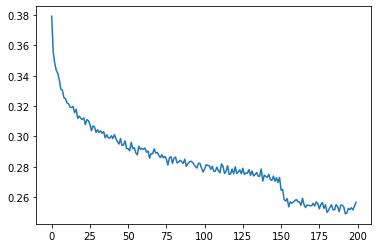

In [65]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1));

In [66]:
# put layers into eval mode (needed for batchnorm especially)
for layer in model.layers:
    layer.training = False

In [67]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.7690415382385254
val 1.9936139583587646


In [68]:
# sample from the model

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        # forward pass the neural net
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1).item()
        # shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # if we sample the special '.' token, break
        if ix == 0:
            break

    print(''.join(itos[i] for i in out)) # decode and print the generated word

arlij.
chetta.
heago.
rocklei.
hendrix.
jamylie.
broxin.
denish.
anslibt.
marianah.
astavia.
annayve.
aniah.
jayce.
nodiel.
remita.
niyelle.
jaylene.
aiyan.
aubreana.


----
### Let's visualize the model layers and parameters' shapes

---

In [69]:
for layer in model.layers:
    print(layer.__class__.__name__, ':', tuple(layer.out.shape))

Embedding : (1, 8, 24)
FlattenConsecutive : (1, 4, 48)
Linear : (1, 4, 128)
BatchNorm1d : (1, 4, 128)
Tanh : (1, 4, 128)
FlattenConsecutive : (1, 2, 256)
Linear : (1, 2, 128)
BatchNorm1d : (1, 2, 128)
Tanh : (1, 2, 128)
FlattenConsecutive : (1, 256)
Linear : (1, 128)
BatchNorm1d : (1, 128)
Tanh : (1, 128)
Linear : (1, 27)


In [70]:
_layers = [layer.__class__.__name__ for layer in model.layers]
# _layers

_layer = [f'FlattenConsecutive+Linear' if i == 'FlattenConsecutive' and j == 'Linear' else 
 i if i != 'FlattenConsecutive' else j for i, j in zip(_layers, _layers[1:] + [''])]
#_layer

i = 0
while i < len(_layer):
    if _layer[i] == 'FlattenConsecutive+Linear' and i < len(_layer) - 1 and _layer[i+1] == 'Linear':
        _layer.pop(i+1)
    else:
        i += 1
        
_layer

['Embedding',
 'FlattenConsecutive+Linear',
 'BatchNorm1d',
 'Tanh',
 'FlattenConsecutive+Linear',
 'BatchNorm1d',
 'Tanh',
 'FlattenConsecutive+Linear',
 'BatchNorm1d',
 'Tanh',
 'Linear']

In [71]:
for name, param in zip(_layer, model.parameters()):
    print(f"Parameter Layer: {str(name):25s}   |   shape {param.shape}")

Parameter Layer: Embedding                   |   shape torch.Size([27, 24])
Parameter Layer: FlattenConsecutive+Linear   |   shape torch.Size([48, 128])
Parameter Layer: BatchNorm1d                 |   shape torch.Size([128])
Parameter Layer: Tanh                        |   shape torch.Size([128])
Parameter Layer: FlattenConsecutive+Linear   |   shape torch.Size([256, 128])
Parameter Layer: BatchNorm1d                 |   shape torch.Size([128])
Parameter Layer: Tanh                        |   shape torch.Size([128])
Parameter Layer: FlattenConsecutive+Linear   |   shape torch.Size([256, 128])
Parameter Layer: BatchNorm1d                 |   shape torch.Size([128])
Parameter Layer: Tanh                        |   shape torch.Size([128])
Parameter Layer: Linear                      |   shape torch.Size([128, 27])


----
<a id='b1'></a>
### <u>Model Performance Log for Different Scenarios:</u>


|  | Context Size | Kernel Size | Embedding Dimension | Hidden Neurons | Parameters | Train loss | Val. loss |
| --- | --- | --- | --- | --- | --- | --- | --- |
| Original | 3 | - | 10 | 200 | 12k | 2.058 | 2.105 |
| Case $1$ (Context size: $3\rightarrow8$) | 8 | - | 10 | 200 | 22k | 1.918 | 2.027 |
| Case $2a$ (Flat $\rightarrow$ Hierarchical) | 8 | 2 | 10 | 68 | 22k | 1.941 | 2.031 |
| Case $2b$ (Fix bug in `BatchNorm1d`) | 8 | 2 | 10 | 68 | 22k | 1.912 | 2.022 |
| Case $2c$ (Scaling up the network) | 8 | 2 | 24 | 128 | 76k | 1.769 | 1.993 |

---------
<br><br><a id="3"></a>
# 3.  Summary
-------------------------------------------------------


------
## 3.1.  Experimental Harness<a id="301"></a>
-----

The training takes a lot longer even though we've crossed over the $2.0$ loss threshold to $1.99$. We're a little bit in the dark $w.r.t$ the correct setting of the hyperparameters and the learning rates because the experiments are starting to take longer to train. Basically, we're missing an experimental harness on which we could run a number of experiments and really tune this architecture very well.


------
## 3.2. WaveNet but with **"Dilated Causal Convolutions"**<a id="302"></a>
-----
Although we did implement the dilated causal convolutional layer architecture from the WaveNet paper, we did not implement the complex gated linear layer, residual connections and skip connections from the same paper. Overall, basically the use of convolutions is strictly for efficiency, it doesn't actually change the model we've implemented.
<br><br>
**Convolution is like a for-loop**<br>
Let’s say we are only considering this one name, which gives us 8 independent examples.

In [72]:
for x,y in zip(Xtr[7:15], Ytr[7:15]):
    print(''.join(itos[ix.item()] for ix in x), '-->', itos[y.item()])

........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .


In [73]:
Xtr[[7]].shape # convert to list of 7

torch.Size([1, 8])

If we wanted to forward this single example, we can put the single example in a 1D tensor. 

In [74]:
# forward a single example:
logits = model(Xtr[[7]])
logits.shape

torch.Size([1, 27])

If we wanted to forward all $8$ examples, we could put it in a `for` loop but we would then have to call our model $8$ times (one for each example).

In [75]:
# forward all of them
logits = torch.zeros(8, 27)
for i in range(8):
    logits[i] = model(Xtr[[7+i]])
logits.shape

torch.Size([8, 27])

In [76]:
# calculate all of them as a batch
#logits = model(Xtr[7:15])
#logits.shape

If we consider the original diagram in the Wavenet paper as seen in **[Figure 1](#a1)**, what we implemented is basically just the black tree-like structure which calculates a single output. Even if we batched all of our 8 examples, we would need to then recreate the tree 8 times, each one unit shifted over. With convolutions (which we did not implement), the intermediate nodes actually can get reused since we are computing all of the outputs in parallel (ie the dotted lines).

In [77]:
# convolution is a "for loop"
# allows us to forward Linear layers efficiently over space

Convolutions is a linear filter which can be applied over a certain space. It allows for sliding of model efficiently over the input sequence.  It can be used to run a for loop in a parallel manner over kernels in CUDA. Moreover, we can re-use the variables. Convolutions are very efficient because:

* the for loop is inside the Cuda kernels in the sliding which makes it efficient
* of variable re-use: child nodes are used twice

------
## 3.3. `torch.nn`<a id="303"></a>
-----

We've implemented all the layer LEGO building blocks or module building blocks, and the containers. Overall, we've `PyTorch`-ified our code quite a bit more. Basically, we're re-implementing `torch.nn`, which is the neural networks library on top of `torch.tensor`. It's fair to say that with our experience so far, we've unlocked `torch.nn`, understand its components, how the modules work, how they're nested and what they're doing on top of `torch.tensor`. This will allow us to start using `torch.nn` directly.

------
## 3.4. Development Process of Building Deep Neural Nets (DNNs)<a id="304"></a>
-----
We also get a sense of what the development process of building deep neural networks (DNNs) looks like which was relatively representative to some extent.
1. A lot of time is spent in the documentation pages of `PyTorch`, reading through all the layers, perusing the documentations, figuring out the shapes of the inputs, figuring out the functions of each layer
2. There is a significant importance in ensuring that the shapes work. A lot of gymnastics exist around these multi-dimensional arrays ($2D, 3D, 4D, etc$). What layers take what shapes? Is it NCL or NLC (`BatchNorm1d`)? When do you use `.permute` and/or `.view`? With all these questions, it can get pretty messy.
3. A good practice for building DNNs involves prototyping these layers and their implementations in jupyter notebooks to ensure that all the shapes work out and upon satisfaction of full functionality then the notebook code can be copied and pasted into a repository of actual training code. VSCode + JupyterNB side-by-side helps in prototyping too.

------
## 3.5. Going Forward: Improvements !!!<a id="305"></a>
-----
So far, this lecture unlocks a lot of potential for further lectures such as:
1. Converting our neural network to actually use these dilated causal convolutional layers, so implementing ConvNets.
2. Getting into the meaning of residual and skip connections, and why are they are useful.
3. Setting up typical deep learning workflows with proper evaluation harness, standard experiments, diagnostic analysis of loss plots (train and validation), population level learning, hyperparameter searches & optimizations
4. Learning about recurrent neural networks (RNNs), LSTMs, GRUs & Transformers.

---------
<br><br><a id="4"></a>
# 4. Conclusion
---
This notebook was aimed at building a character-level language model using a WaveNet-inspired architecture. The goal is to predict the next character in a sequence. We:
- Introduced the architecture and starter code, similar to Part 3 of the makemore series.
- Simplified the generator function, added layers, and initialized parameters.
- Implemented embedding and flattening module operations à la `PyTorch`.
- Introduced `PyTorch` containers to organize layers and wrote a sequential layer.
- Implemented a WaveNet architecture with a progressive fusion of context.
- Discussed the importance of hierarchical schemes and batch dimensions.
- Introduced a new way of concatenating input vectors using `PyTorch`'s `.view` function.
- Inspected layer shapes, restructured the WaveNet, and fixed a bug in the batch normalization layer.
- Improved validation performance to $1.99$ and discussed hyperparameter tuning.
- Related the model to convolutional neural networks and discussed efficient computing.
- Discussed the development process of DNNs and potential further experimentation to achieve better results.


A good challenge would be to try and beat the current result and explore more effective methods.


-----
<br><br><a id="e1"></a>
# Exercises
----

1. Beat validation loss of $1.993$ with any improvements.

-----
<br><br><a id="c3"></a>
## Appendix - Convolutions: Kernel, Stride, Padding, Bias
----
![convolution](_imgs/convolution.png)
![kernel, stride, padding, bias](_imgs/kernel_stride_padding_bias.png)

[Source](https://lena-voita.github.io/nlp_course/models/convolutional.html)

-----
<br><br><a id="r1"></a>
# References
----
1. "<u>Building makemore Part 5: Building a WaveNet</u>" [youtube video](https://www.youtube.com/watch?v=t3YJ5hKiMQ0), Nov 2022.
2. Andrej Karpathy **Makemore** [github repo](https://github.com/karpathy/makemore).
3. Andrej Karpathy  **Neural Networks: Zero to Hero** [github repo](https://github.com/karpathy/nn-zero-to-hero/tree/master) ([notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part5_cnn1.ipynb) to follow video tutorial with).
4. Article: "<u>Wavenet with Andrej Karpathy</u>" - Kavishka Abeywardana, Pt [1](https://medium.com/@kdwa2404/wavenet-with-andrej-karpathy-part-1-65bcb79716d6), [2](https://medium.com/@kdwa2404/wavenet-with-andrej-karpathy-part-2-15814513080d), March 2024.
5. "<u>Time Series Forecasting with Convolutional Neural Networks - a Look at WaveNet</u>" - Joseph Eddy, [blog](https://jeddy92.github.io/ts_seq2seq_conv/), Jun 2018.
6. "<u>Makemore Part 5 - Building a WaveNet</u>" - Anson Chu, [blog](https://ansonchu.com/zero-to-hero/makemore-part-5-building-a-wavenet), Dec 2023.
7. "<u>Understanding Convolutions</u>" - Christopher Olah, [blog](https://colah.github.io/posts/2014-07-Understanding-Convolutions/), Jul 2014.
8. "<u>Convolutional Neural Networks for Text</u>" - Elena Voita, [article](https://lena-voita.github.io/nlp_course/models/convolutional.html), Nov 2023.
9. "<u>WaveNet: A Generative Model for Raw Audio</u>" - Aäron van den Oord, Sander Dieleman, [blog](https://deepmind.google/discover/blog/wavenet-a-generative-model-for-raw-audio/), Sep 2016.
10. "<u>WaveNet: A Generative Model for Raw Audio</u>" - Aaron van den Oord et. al., [Academic Paper](https://arxiv.org/abs/1609.03499), Google Deepmind, Sep 2016.
11. "<u>A Neural Probabilistic Language Model</u>" - Bengio et. al., [Academic Paper](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf), Journal of Machine Learning Research, Vol 3. 1137–1155. Mar 2003.
12. PyTorch Resources: [Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html), [BatchNorm1d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html), [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh), [`torch.squeeze`](https://pytorch.org/docs/stable/generated/torch.squeeze.html),
[Dimension ordering: NLC vs NCL vs LNC](https://discuss.pytorch.org/t/inconsistent-dimension-ordering-for-1d-networks-ncl-vs-nlc-vs-lnc/14807/3)
------